# TAOS2: clean ship data

**taos2-drifters0:** 
Manually concatenate `ship_hydrophone_05052023_a`, `ship_hydrophone_05052023_b`, `ship_hydrophone_05052023_c`.

**taos2-drifters1:** 
RAS

In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import cmocean.cm as cm

import numpy as np
import pandas as pd
import xarray as xr

#
import pynsitu as pin
from pynsitu.maps import crs
import taos.sensors as se

In [7]:
## taos
root_dir = "/Users/aponte/Current_Projects/taos/campagnes/taos2/"

# taos2-drifters0
campaign="taos2_drifters0"
yaml = f"drifters0/{campaign}.yaml"
ships = ["hydrophone", "delphy"]

# taos2-drifters1
campaign="taos2_drifters1"
yaml = f"drifters1/{campaign}.yaml"
ships = ["delphy", "hydrophone", "parceque"]

cp = pin.Campaign(os.path.join(root_dir,yaml))

# plot all deployments
for label, deployment, platform, sensor, meta in cp.get_all_deployments():
    print(label, platform, sensor, deployment)

day0 None None day0 / start 2023-06-12 07:00:00 / end 2023-06-12 23:00:00
day1 None None day1 / start 2023-06-13 07:00:00 / end 2023-06-13 23:00:00
day2 None None day2 / start 2023-06-15 07:00:00 / end 2023-06-15 23:00:00
d0 drifter0 None d0 / start 2023-06-12 16:24:37 -0.25 49.34 / end 2023-06-15 06:14:43 -0.11 49.33
d0 drifter1 None d0 / start 2023-06-12 16:34:57 -0.25 49.33 / end 2023-06-15 06:27:04 -0.12 49.35
d0 drifter2 None d0 / start 2023-06-12 16:43:50 -0.26 49.32 / end 2023-06-15 06:28:53 -0.12 49.35
d0 drifter3 None d0 / start 2023-06-12 16:47:05 -0.27 49.33 / end 2023-06-15 08:55:31 -0.16 49.32
d0 drifter4 None d0 / start 2023-06-12 16:53:13 -0.26 49.33 / end 2023-06-15 08:58:57 -0.15 49.32
d0 drifter5 None d0 / start 2023-06-12 17:12:29 -0.26 49.34 / end 2023-06-15 09:12:31 -0.10 49.32
d0 drifter6 None d0 / start 2023-06-12 17:24:28 -0.27 49.34 / end 2023-06-15 09:05:32 -0.15 49.32
d0 drifter7 None d0 / start 2023-06-12 17:26:17 -0.28 49.33 / end 2023-06-15 08:55:51 -0.16 

---

## ships


In [25]:
# search for deployments
s = ships[0]
#s = ships[1]
#s = ships[2]

deployments = list(cp[s]["deployments"])

# select a deployment to process
d = deployments[0] # d0
#d = deployments[1] # d1
#d = deployments[2] # d2

print(f"processing ship {s}")
print("Available deployments: "+" / ".join(deployments))
print(f"Working with deployment {d} here")

# need to manually set correct day
#cday = dict(year=2023, month=6, day=13) # taos2-drifters1 - delphy - d1
cday = cp[s][d].start.time.floor("1D").tz_localize("UTC")

# load data
D = dict()
#for s in ships:
#    if d in cp[s]["deployments"]:
file = os.path.join(cp["path_raw"], cp[s][d]["file"])
D[s] = se.read_lern_ship(file, correct_day=cday)

processing ship delphy
Available deployments: d0 / d1
Working with deployment d0 here
columns:
['ï»¿ID', 'trksegID', 'lat', 'lon', 'ele', 'time', 'magvar', 'geoidheight', 'name', 'cmt', 'desc', 'src', 'sym', 'type', 'fix', 'sat', 'hdop', 'vdop', 'pdop', 'ageofdgpsdata', 'dgpsid', 'Temperature', 'Depth', 'wtemp', 'hr', 'cad', '']
Fix first time from 2023-06-13 07:49:05+00:00 to 2023-06-13 07:49:05+00:00


In [ ]:
#s = "hydrophone"
#if s in ships:
D[s].geo.plot_bokeh(deployments=cp[s][d]) #
D[s].geo.plot_on_map()

### store

In [27]:
# store
#for s in ships:
df = D[s].ts.trim(cp[s][d])
(df.to_xarray()
 .to_netcdf(os.path.join(cp["path_processed"], f'{s}_{d}.nc'), mode="w")
)
df.head()

,longitude,latitude,water_depth,air_temperature
time,,,,
2023-06-13 07:50:24,-0.094060,49.294532,0.0,0.0
2023-06-13 07:50:58,-0.093115,49.294802,0.0,0.0
2023-06-13 07:51:37,-0.091992,49.295101,0.0,0.0
2023-06-13 07:52:13,-0.090915,49.295301,0.0,0.0
2023-06-13 07:52:54,-0.089636,49.295482,0.0,0.0


### other plots

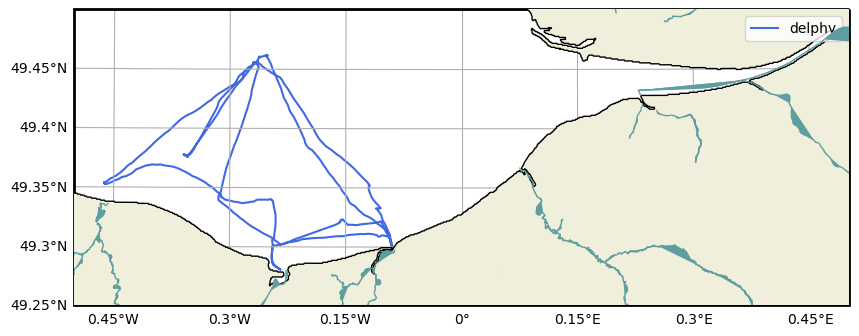

In [29]:
#bounds=[-.5, -.1, 49.25, 49.5]
#bounds=[-.5, .0, 49.25, 49.5]
fig, ax, cbar = cp.map() # extent=bounds

#for s in ships:
ax.plot(D[s].longitude, D[s].latitude, transform=crs, label=s, color=cp[s]["color"],)

ax.legend()

### Inspect typical time interval between ship positions.

Typically around 10 seconds

Text(0.5, 0, '[s]')

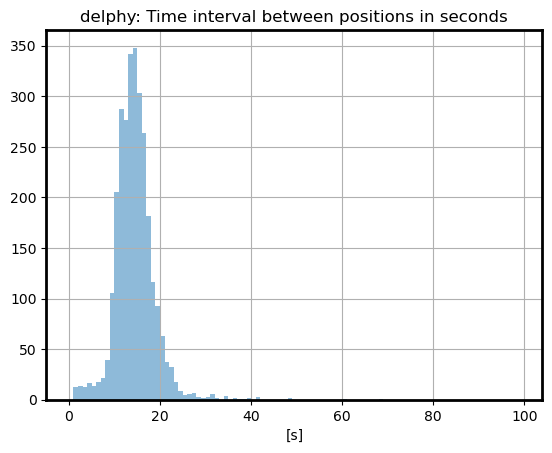

In [30]:
#for s in ships:

_df = D[s].reset_index()
_df["dt"] = _df["time"].diff()/pd.Timedelta("1s")
_df["dt"].hist(bins=np.arange(0,100,1), alpha=0.5)
plt.title(s+": Time interval between positions in seconds")
plt.xlabel("[s]")